In [47]:
#new working document which uses the data generated from nasa instead with different units

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from astropy import units as u
from astropy import constants as const
from astropy.modeling.models import BlackBody
from scipy.signal import find_peaks

In [49]:
#Inputting the data

def input_spectra(gasname, filepath, isheader, separation, wavelengthunits, wavelengthcol, datacol):
    """
    This function input_spectra loads in the datafile for the spectral information and assigns values to the wavelength and spectral data.
    
    Parameters include:
        - gasname                   : user inputs the name of the gas 
        - filepath                  : input file with at least one column for wavelength given in nanometers (nm) or micrometres (um)
                                      and one column for spectral line intensity. Needs to be contained within "".  
        - isheader                  : parameter takes in whether there is a header in the file. None means there is no header present
        - separation                : parameter takes in what the separation between the variables within the file
                                      e.g. "\t" means values separated by a tab
        - wavelengthunits           : enter the units of the wavelength data, input "um" or "nm", function will convert units into um. 
        - wavelengthcol             : user inputs which column consists of the wavelength values
        - datacol                   : user inputs which column consists of the spectra data values
        - gas_wavelength            : variable consisting of the wavelength data
        - gas_absorption_line_data  : variable consisting of the gas absorption data
    """

    # ~~~~~ Inputs the data file
    gas_raw_data = pd.read_csv(filepath, header = isheader, sep = separation).values #stores the file into a variable 
    gas_wavelength = (gas_raw_data[:,wavelengthcol]).astype(float) #variable stores the wavelength range
    gas_absorption_line_data = (gas_raw_data[:,datacol]).astype(float) #variable stores the absorption line data for each line 
    
    if wavelengthunits == "um":
        gas_wavelength = gas_wavelength #leaves the wavelength units in micrometres (um)
    elif wavelengthunits == "nm": 
        gas_wavelength = (gas_wavelength/1000.0) #converts the wavelength units into micrometres (um)
    else:
        print("Please input the wavelength as um or nm")  

    return gasname, gas_wavelength, gas_absorption_line_data

In [50]:
#Testing function using generated data from NASA PSG
gasname, spectra_wav, spectra_data = input_spectra('Methane (NASA PSG)', '/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/New Code/ch4 psg_trn (1).txt', None, ' ', 'um', 0, 2)

In [51]:
# Function plots spectra for a given file 

def plot_spectra(gasname, spectra_wav, spectra_data, plot_min, plot_max):
   """
   This function provides a plotting facility for the input gas data file as a simple line graph, with wavelength and transmittance. 

   The parameters include: 
      - gasname         : input requires the name of the gas
      - spectra_wav     : loads in the wavelengths 
      - spectra_data    : loads in the spectral data  
      - plot_min        : user has a choice to input a minimum value for the x-axis (wavelength) else input 'None' 
      - plot_max        : user has a choice to input a maximum value for the x-axis (wavelength) else input 'None'
   """

   gas_wavelength = spectra_wav
   gas_absorption_line_data = spectra_data

   if plot_min is not None and plot_max is not None: 
      # ~~~~~ Plot with custom limits
      plt.figure(figsize=(15, 4))
      plt.plot(gas_wavelength, gas_absorption_line_data)
      plt.xlim([plot_min, plot_max])
      plt.title('Transmittance spectrum of ' + gasname + ' gas')
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Transmittance')
      plt.show()
   else: 
      # ~~~~~ Plot without custom limits
      plt.figure(figsize=(15, 4))
      plt.plot(gas_wavelength, gas_absorption_line_data)
      plt.title('Transmittance spectrum of ' + gasname + ' gas')
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Transmittance')
      plt.show()

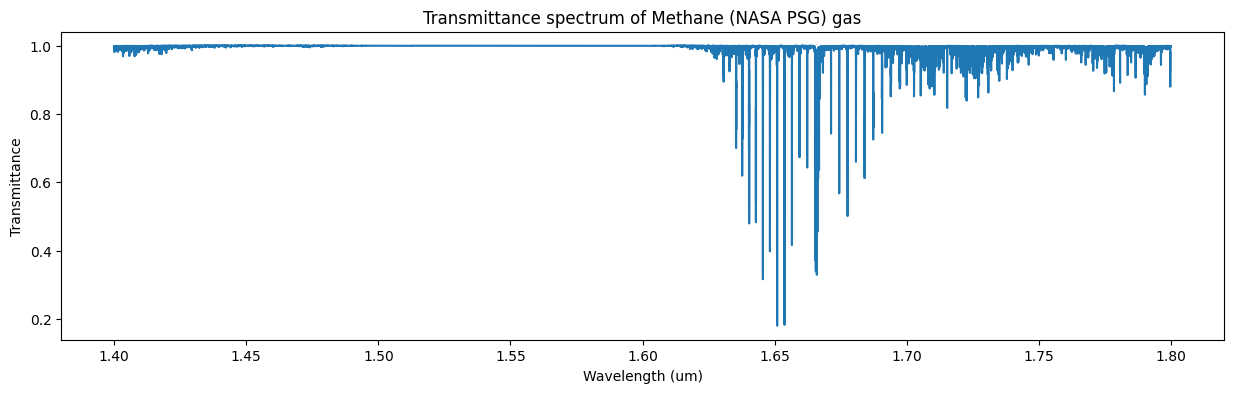

In [52]:
#Testing plot function
plot_spectra(gasname, spectra_wav, spectra_data, None, None)

In [53]:
def fit_curves(spectra_wav, spectra_data, detection_height, plot_min, plot_max, model):
    """
    This function first detects peaks for the spectral data by converting it from a transmittance spectrum to an absorption spectrum,
    and then plots a model - either Lorentzian or a Gaussian - to the input gas data. 

    The parameters include: 
      - spectra_wav     : loads in the wavelengths 
      - spectra_data    : loads in the spectral data  
      - detection_height: input a value for a spectral line to classify as a peak 
      - plot_min        : user has a choice to input a minimum value for the x-axis (wavelength) else input 'None'  
      - plot_max        : user has a choice to input a maximum value for the x-axis (wavelength) else input 'None'
      - model           : choose to either fit a 'gaussian' or the default will be a lorentzian curve to the data
   """

    x_values = np.array(spectra_wav)
    y_values = np.array(1.0 - spectra_data) #converting to absorption sepctrum so function can find peaks

    peaks, properties = find_peaks(y_values, height= detection_height, width = 0) #properties include, peak heights, peak widths, etc. 
     
    # ~~~~~ PLOTS DETECTED PEAKS ONLY WITH CHOICE OF X AXIS LIMITS
    if plot_min is not None and plot_max is not None:
        # Plot with custom limits
        figure(figsize=(15, 4))
        plt.plot(x_values, y_values)
        plt.plot(x_values[peaks], y_values[peaks], "x")
        plt.xlim([plot_min, plot_max])
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Absorption')
        plt.title('Visualise detected peaks')
        plt.show()
    else:
        # Plot without custom limits
        figure(figsize=(15, 4))
        plt.plot(x_values, y_values)
        plt.plot(x_values[peaks], y_values[peaks], "x")
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Absorption')
        plt.title('Visualise detected peaks')
        plt.show()

    # ~~~~~ PLOTS DATA WITH GAUSSIAN OR LORENTZIAN MODELS 
    if model == 'gaussian': 
        def gaussian(x, sigma, mu, amp):
            return amp*1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)**2/(2*sigma**2))

        peak = np.array(x_values[peaks]) #since peaks is an array of indexes, associating each index to it's wavelength value
        #widths = np.array(properties['widths']) #array of all the widths
        widths = 0.00001 
        amps = np.array(properties['peak_heights']) #array of all the heights

        x = np.array(spectra_wav)
        y_g = np.zeros(x.shape) 

        for i in range(len(peaks)): #for each peak in the range of the length of the number of peaks... 
            g = gaussian(x, sigma=widths, mu=peak[i], amp=amps[i]) #fit this gaussian
            y_g += g

        scale = max(y_g)/max(properties['peak_heights'])
        amps_scaled = np.array(properties['peak_heights']) / scale #array of all the heights

        y_gscaled = np.zeros(x.shape) 

        for i in range(len(peaks)): #for each peak in the range of the length of the number of peaks... 
            g = gaussian(x, sigma=widths, mu=peak[i], amp=amps_scaled[i]) #fit this gaussian
            y_gscaled += g

        transmittance = 1 - y_gscaled

        # ~~~~~ PLOTS GAUSSIAN MODEL WITH CHOICE OF X AXIS LIMITS 
        if plot_min is not None and plot_max is not None:
            # Plot with custom limits
            figure(figsize=(15, 4))
            plt.plot(x, transmittance, color = 'y')
            plt.xlim([plot_min, plot_max])
            plt.xlabel('Wavelength (um)')
            plt.ylabel('Transmittance')
            plt.title('Fitting a Gaussian')
            plt.legend(['Gaussian fitted spectrum'])
            plt.show()
        else: 
            # Plot without custom limits
            figure(figsize=(15, 4))
            plt.plot(x, transmittance, color = 'y')
            plt.xlabel('Wavelength (um)')
            plt.ylabel('Transmittance')
            plt.title('Fitting a Gaussian')
            plt.legend(['Gaussian fitted spectrum'])
            plt.show()

    else:
        def lorentzian(x, sigma, mu, amp):
            return (amp/np.pi) * (sigma/((x-mu)**2 + sigma**2))

        peak = np.array(x_values[peaks]) 
        #widths = np.array(properties['widths']) 
        widths = 0.00001 
        amps = np.array(properties['peak_heights']) #array of all the heights

        x = np.array(spectra_wav)
        y_l = np.zeros(x.shape) 

        for i in range(len(peaks)):
            lor = lorentzian(x, sigma=widths, mu=peak[i], amp=amps[i])
            y_l += lor

        scale = max(y_l)/max(properties['peak_heights'])
        amps_scaled = np.array(properties['peak_heights']) / scale #array of all the heights

        y_lscaled = np.zeros(x.shape) 

        for i in range(len(peaks)):
            lor = lorentzian(x, sigma=widths, mu=peak[i], amp=amps_scaled[i])
            y_lscaled += lor

        transmittance = 1 - y_lscaled
        
        # ~~~~~ PLOTS LORENTZIAN MODEL WITH CHOICE OF X AXIS LIMITS
        if plot_min is not None and plot_max is not None: 
            # Plot with custom limits
            figure(figsize=(15, 4))
            plt.plot(x, transmittance, color = 'y')
            plt.xlim([plot_min, plot_max])
            plt.xlabel('Wavelength (um)')
            plt.ylabel('Transmittance')
            plt.title('Fitting a Lorentzian')
            plt.legend(['Lorentzian fitted spectrum'])
            plt.show()
        else: 
            # Plot without custom limits
            figure(figsize=(15, 4))
            plt.plot(x, transmittance, color = 'y')
            plt.xlabel('Wavelength (um)')
            plt.ylabel('Transmittance')
            plt.title('Fitting a Lorentzian')
            plt.legend(['Lorentzian fitted spectrum'])
            plt.show()

    return transmittance

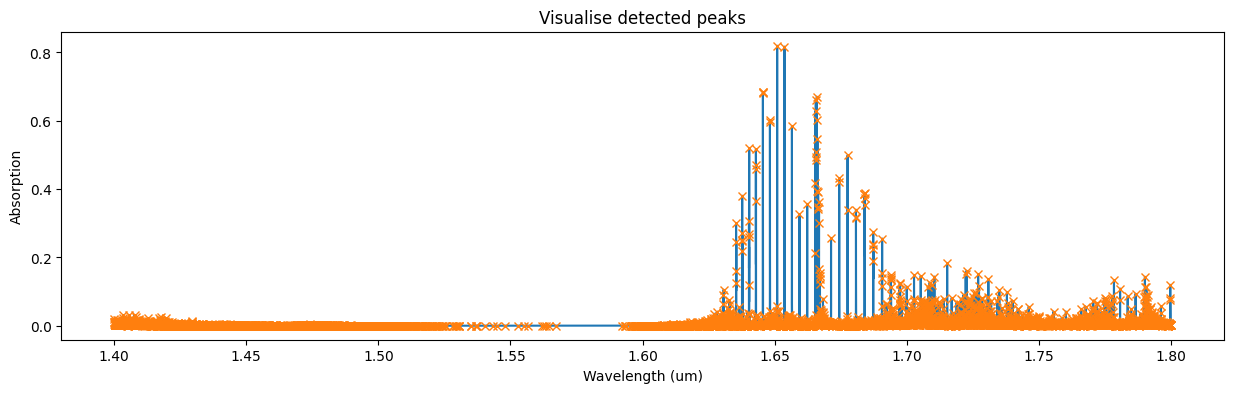

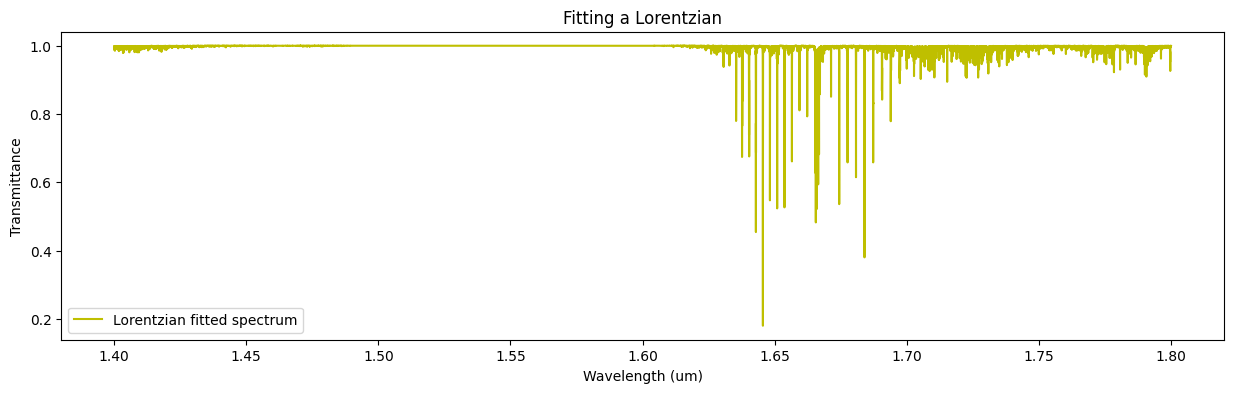

In [54]:
#Testing function
transmittance = fit_curves(spectra_wav, spectra_data, 0.000010, None, None, 'lorentzian')

In [55]:
def blackbodyabsorption(wavelength, spectra_data, temp, xlimits, ylimits): 
   """
   Function returns a blackbody radiation curve at the chosen temperature with the absorption of the provided gas. 

   The parameters include: 
      - wavelength            : loads in the wavelengths
      - spectra_data          : loads in the spectral data
      - temp                  : temperature of the blackbody
      - xlimits               : user has a choice to input a range of x values (wavelength) i.e.,  [ , ]
      - ylimits               : user has a choice to input a range of y values (Transmitted Intensity) i.e.,  [ , ]
      - flux                  : variable consists of the calculated blackbody flux for the given wavelengths 
      - transmitted_intensity : variable consists of the absorption applied to a blackbody of given temperature 
   """

   bb = BlackBody(temperature = temp*u.K)
   wavelength_units = (wavelength*10000)*(u.AA) #confusion regarding the units until cleared leaving it as angstrom
   flux = bb(wavelength_units)
   transmittance = spectra_data
   transmitted_intensity = transmittance*flux
 
   if xlimits is not None and ylimits is not None: 
      # Plot with custom limits
      plt.figure(figsize=(15, 6))
      plt.plot(wavelength, transmitted_intensity)
      plt.xlim(xlimits)
      plt.ylim(ylimits)
      plt.title('Blackbody absorption spectrum of' + ' ' + gasname + ' ' + 'gas')
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Transmitted Intensity (erg / cm2 Hz s sr)')
      plt.show()
   else: 
      # Plot without custom limits
      plt.figure(figsize=(15, 6))
      plt.plot(wavelength, transmitted_intensity)
      plt.title('Blackbody absorption spectrum of' + ' ' + gasname + ' ' + 'gas')
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Transmitted Intensity (erg / cm2 Hz s sr)')
      plt.show()
      
      
   return flux, transmitted_intensity

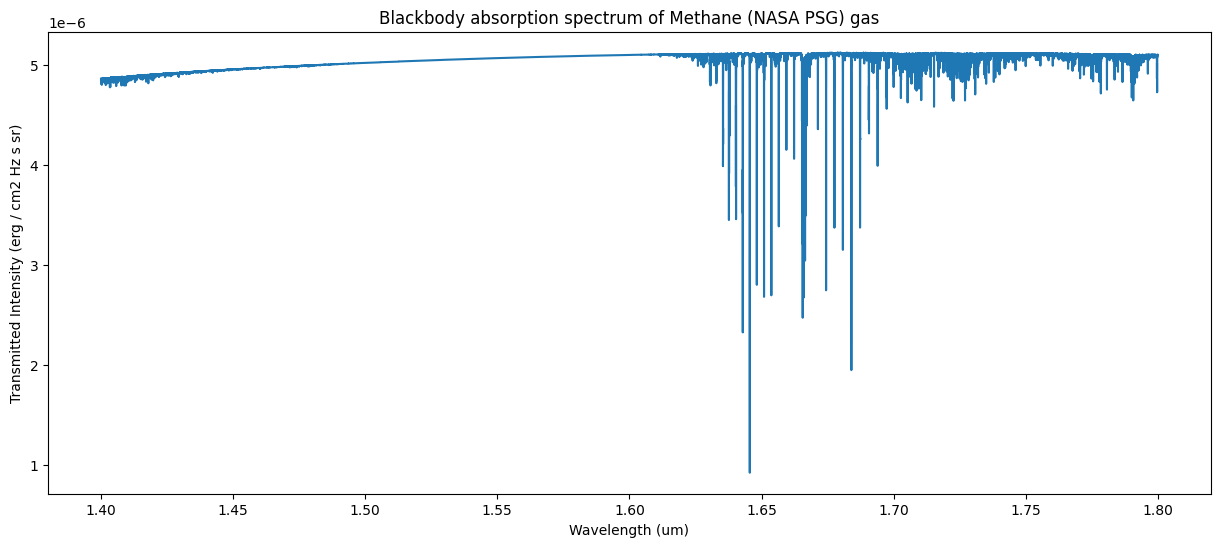

In [56]:
#testing function for plotting blackbody and flux 
flux, transmitted_intensity = blackbodyabsorption(spectra_wav, transmittance, 3000, None, None)

In [57]:
#Converting from flux units erg /(cm2 Hz s sr) to photon counts (photons/sec)

def convert_fluxunits_to_photoncounts(wavelength, flux, emission_coefficient, area, solid_angle, xlimits, ylimits):
    """
    Function allows the conversion of the flux values to photon counts and plots a graph. 
    
    Parameters: 
        - wavelength            : loads in the wavelengths (um)
        - flux                  : input flux value to be converted into photon counts (erg /(cm2 Hz s sr))
        - emisson_coefficient   : requires the emission coefficient of the light source filament at a 
                                  particular temperature 
        - area                  : area of the fibre cross-section (cm^2)
        - solid_angle           : solid angle (steradians) that reaches the fibre core of a particular 
                                  diameter
        - photoncount           : variable consists of all the flux values converted into photons/nm sec with units
        - photoncount_value     : variable consists of all the flux values converted into photons/nm sec without units
    """
    tc = emission_coefficient
    A = area 
    sr = solid_angle 
    c = const.c.value
    h = const.h.value
    unitless_flux = flux.value 
    frequency = c/(wavelength*(10**(-6))) #calculates the frequency by first converting the wavelength to metres from um
    energy = h*c*frequency
    new_flux = unitless_flux*10**(-7) #such that erg /(cm2 Hz s sr) --> J /(cm2 Hz s sr)
    
    photoncount_persec = (tc*new_flux*A*sr*frequency)/energy # photons per sec

    if xlimits is not None and ylimits is not None: 
      # Plot with custom limits
        figure(figsize=(15, 4))
        plt.plot(wavelength, photoncount_persec)
        plt.title('Photon counts (per sec) for' + ' ' + gasname + ' ' + 'gas')
        plt.xlim(xlimits)
        plt.ylim(ylimits)
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Photons / sec')
        plt.show()
    else:
        # Plot without custom limits
        figure(figsize=(15, 4))
        plt.plot(wavelength, photoncount_persec)
        plt.title('Photon counts (per sec) for' + ' ' + gasname + ' ' + 'gas')
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Photons / sec')
        plt.show()

    return photoncount_persec

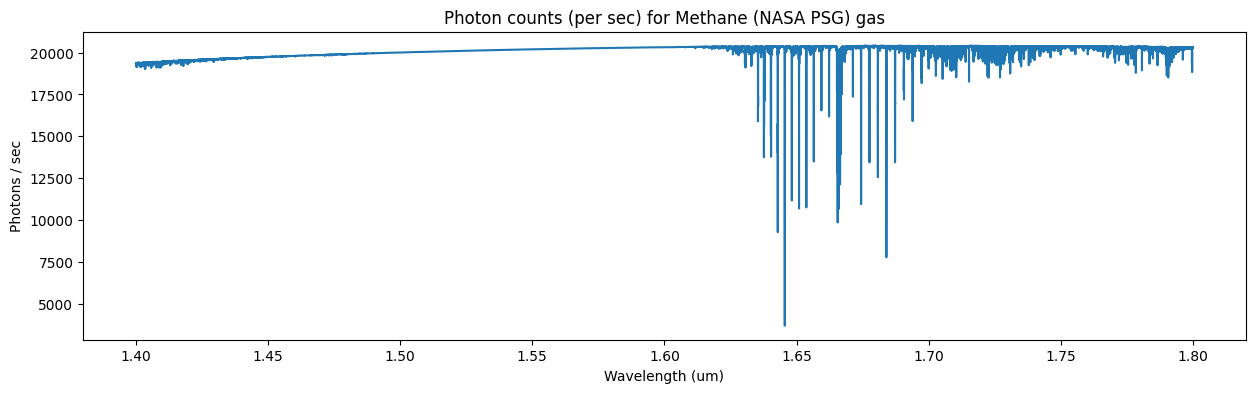

In [58]:
#testing unit conversion function

photoncount_persec = convert_fluxunits_to_photoncounts(spectra_wav, transmitted_intensity, 0.35, 0.000000503, 0.045, None, None)
